# Experiment 6: Indirect-contrl ZNE with ideal noise-free time-evolution gate
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse filed Ising Hamiltonian.
- Ansatz time-evolution: Heisenberg-Hamiltonian.

### Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

### Matplotlib set-sup

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 11

### Parsing the ZNE data

The raw experimental are available at `experimental data/data`. The following code parses the ZNE data:

In [3]:
# Folder containing your JSON files
folder_path = "experimental data/data"

# List to store the data from the filtered JSON files
all_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "ZNE" in filename:  # Check if the file is a JSON file and contains "ZNE"
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            all_data.append(data)  # Add the parsed data to the list

### Parsing other useful data

To extract other useful data such as exact minimum eigen values, estimated minimum eigen values etc, the VQE data needs to be parsed.

In [4]:
# List to store the data from the filtered JSON files
vqe_data = []
noiseless_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json") and "VQE" in filename:  # Check if the file is a JSON file and contains "ZNE"
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            vqe_data.append(data)  # Add the parsed data to the list
    elif filename.endswith(".json") and "noisefree_vqe" in filename:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            data = json.load(file)  # Parse the JSON file
            noiseless_data.append(data)  # Add the parsed data to the list

### Exact minimum eigen value

In [5]:
exact_sol = vqe_data[0]["output"]["exact_sol"]
print(f"Exact sol: {exact_sol}")

Exact sol: -8.56677223350563


### Mean and standard deviation of estimated minimum energy eigen values (noisy ansatz)

In [6]:
eigen_vals = vqe_data[0]["output"]["optimized_minimum_cost"]
eigen_vals_mean = np.mean(eigen_vals)
print(f"Noisy mean estimation: {eigen_vals_mean}")

Noisy mean estimation: -5.309993052858839


In [7]:
# Standard deviation in eigenvalues
eigen_vals_sd = np.std(eigen_vals)
print(f"Noisy standard deviation: {eigen_vals_sd}")

Noisy standard deviation: 0.089912838888468


### Mean and standard deviation of estimated minimum energy eigen values (noise-free ansatz)

In [8]:
noisefree_estimation = noiseless_data[0]["Optimized_minimum_cost"]
noisefree_mean = np.mean(noisefree_estimation)
print(f"Noise-free mean estimation: {noisefree_mean}")

Noise-free mean estimation: -8.450217972952293


In [9]:
noisefree_sd = np.std(noisefree_estimation)
print(f"Noise-free standard deviation: {noisefree_sd}")

Noise-free standard deviation: 0.06830077032241505


In [10]:
noise_level = vqe_data[0]["config"]["vqe"]["ansatz"]["noise"]["value"]

### Mean and standard deviation of ZNE values

In [11]:
zne_vals = []
for data in all_data:
    zne_val = data["output"]["zne_values"]["extrapolated_value"]
    zne_vals.append(zne_val)

zne_mean = np.mean(zne_vals)
print(f"ZNE mean: {zne_mean}")


ZNE mean: -6.8842147276495


In [12]:
zne_sd = np.std(zne_vals)
print(f"ZNE standard deviation: {zne_sd}")

ZNE standard deviation: 0.09344990918566992


### Plotting result

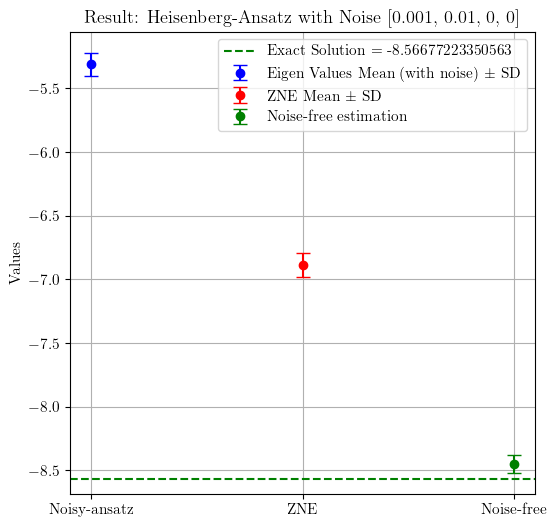

In [13]:
# Data labels
labels = ["Noisy-ansatz", "ZNE", "Noise-free"]

# Values to plot
means = [eigen_vals_mean, zne_mean, noisefree_mean]
sds = [eigen_vals_sd, zne_sd, noisefree_sd]

# Create the plot with error bars
plt.figure(figsize=(6, 6))

# Plot eigenvalues with error bars
plt.errorbar(labels[0], means[0], yerr=sds[0], fmt="o", color="blue", capsize=5, label="Eigen Values Mean (with noise) ± SD")

# Plot ZNE values with error bars
plt.errorbar(labels[1], means[1], yerr=sds[1], fmt="o", color="red", capsize=5, label="ZNE Mean ± SD")

# Plot ZNE values with error bars
plt.errorbar(labels[2], means[2], yerr=sds[2], fmt="o", color="green", capsize=5, label="Noise-free estimation")

# Plot the horizontal line for the exact solution
plt.axhline(y=exact_sol, color="green", linestyle="--", label=f"Exact Solution = {exact_sol}")

# Adding title and labels
plt.title(f"Result: Heisenberg-Ansatz with Noise {noise_level}")
plt.ylabel("Values")
plt.grid(True)
# Add a legend
plt.legend()
plt.show()